# Can we identify faulty or suboptimally performing equipment?

Time series forcasting framed as a surpervised learning problem - the sliding window method: https://machinelearningmastery.com/time-series-forecasting-supervised-learning/#:~:text=Sliding%20window%20is%20the%20way,using%20the%20sliding%20window%20method.

To solve, we can only identify suboptimal or faulty inverters. For plant 1 this means out of the 22 inverters. 
To classify inverter as a suboptimal, we would first need to know what is subotpimal. This should be basicly viewed from historical data. So plot the data and present suboptimal assumptions. 
So our model should first learn what is suboptimal (and if there even is suboptimal panel in learning period) and only then can we predict which of the panels is suboptimal. 

We need multivariate time series (as multiple variables) and probably multi-step forcasting as single step is not enough (and data can be missing). How many steps should be tested. 


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [302]:
#gd = pd.read_csv("Plant_2_Generation_Data.csv") - initial
#wd = pd.read_csv("Plant_2_Weather_Sensor_Data.csv") - initial wether data
gd=pd.read_csv("Train_Plant1.csv")
print(gd)
print(gd[600:602])

                 DATE_TIME       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0      2020-05-15 00:00:00  1BY6WEcLGh8j5v7            25.184316   
1      2020-05-15 00:00:00  1IF53ai7Xc0U56Y            25.184316   
2      2020-05-15 00:00:00  3PZuoBAID5Wc2HD            25.184316   
3      2020-05-15 00:00:00  7JYdWkrLSPkdwr4            25.184316   
4      2020-05-15 00:00:00  McdE0feGgRqW7Ca            25.184316   
...                    ...              ...                  ...   
53851  2020-06-09 11:45:00  wCURE6d3bPkepu2             0.000000   
53852  2020-06-09 11:45:00  z9Y9gH1T5YWrNuG             0.000000   
53853  2020-06-09 11:45:00  zBIq5rxdHJRwDNY             0.000000   
53854  2020-06-09 11:45:00  zVJPv84UY57bAof             0.000000   
53855  2020-06-09 11:45:00  YxYtjZvoooNbGkE             0.000000   

       MODULE_TEMPERATURE  IRRADIATION   PLANT_ID  DC_POWER  AC_POWER  \
0               22.857507          0.0  4135001.0       0.0       0.0   
1               22.857507          0.

In [303]:
gd['DC_POWER'].mean()

2138.2373460401595

In [304]:
gd.describe()

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,ARTIFICIAL
count,53856.000000,53856.000000,53856.000000,5.385600e+04,53856.000000,53856.000000,53856.000000,5.385600e+04,53856.000000
mean,17.178566,21.261455,0.159539,2.699851e+06,2138.237346,209.077138,2146.633005,4.518132e+06,0.347074
std,12.888103,18.814367,0.278635,1.968442e+06,3692.288592,360.764927,3015.657024,3.310903e+06,0.476044
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,23.027730,21.288265,0.000000,4.135001e+06,0.000000,0.000000,0.000000,6.405833e+06,0.000000
75%,27.205737,33.009210,0.229341,4.135001e+06,3202.401786,314.518750,4986.406250,7.148442e+06,1.000000
max,35.252486,65.545714,1.151102,4.135001e+06,14300.285710,1394.285714,9163.000000,7.770457e+06,1.000000


In [142]:
gd['AC_POWER'].mean()

209.07713826149157

In [143]:
gd['AC_power_mean_dif']=gd['AC_POWER']-gd['AC_POWER'].mean()
gd['AC_power_mean_dif']

0       -209.077138
1       -209.077138
2       -209.077138
3       -209.077138
4       -209.077138
            ...    
53851   -209.077138
53852   -209.077138
53853   -209.077138
53854   -209.077138
53855   -209.077138
Name: AC_power_mean_dif, Length: 53856, dtype: float64

In [144]:
gd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53856 entries, 0 to 53855
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            53856 non-null  object 
 1   SOURCE_KEY           53856 non-null  object 
 2   AMBIENT_TEMPERATURE  53856 non-null  float64
 3   MODULE_TEMPERATURE   53856 non-null  float64
 4   IRRADIATION          53856 non-null  float64
 5   PLANT_ID             53856 non-null  float64
 6   DC_POWER             53856 non-null  float64
 7   AC_POWER             53856 non-null  float64
 8   DAILY_YIELD          53856 non-null  float64
 9   TOTAL_YIELD          53856 non-null  float64
 10  ARTIFICIAL           53856 non-null  int64  
 11  AC_power_mean_dif    53856 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 4.9+ MB


In [145]:
gd['DATE_TIME'] = pd.to_datetime(gd['DATE_TIME'], errors='coerce')

In [146]:
gd['date']=pd.to_datetime(gd['DATE_TIME'].dt.date)
gd['time']=gd['DATE_TIME'].dt.time
gd.head()

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,ARTIFICIAL,AC_power_mean_dif,date,time
0,2020-05-15,1BY6WEcLGh8j5v7,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:00:00
1,2020-05-15,1IF53ai7Xc0U56Y,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6183645.0,0,-209.077138,2020-05-15,00:00:00
2,2020-05-15,3PZuoBAID5Wc2HD,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6987759.0,0,-209.077138,2020-05-15,00:00:00
3,2020-05-15,7JYdWkrLSPkdwr4,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,7602960.0,0,-209.077138,2020-05-15,00:00:00
4,2020-05-15,McdE0feGgRqW7Ca,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,7158964.0,0,-209.077138,2020-05-15,00:00:00


In [147]:
gd['DATE_TIME'].unique()

array(['2020-05-15T00:00:00.000000000', '2020-05-15T00:15:00.000000000',
       '2020-05-15T00:30:00.000000000', ...,
       '2020-06-09T11:15:00.000000000', '2020-06-09T11:30:00.000000000',
       '2020-06-09T11:45:00.000000000'], dtype='datetime64[ns]')

In [148]:
gd['SOURCE_KEY'].unique()

array(['1BY6WEcLGh8j5v7', '1IF53ai7Xc0U56Y', '3PZuoBAID5Wc2HD',
       '7JYdWkrLSPkdwr4', 'McdE0feGgRqW7Ca', 'VHMLBKoKgIrUVDU',
       'WRmjgnKYAwPKWDb', 'ZnxXDlPa8U1GXgE', 'ZoEaEvLYb1n2sOq',
       'adLQvlD726eNBSB', 'bvBOhCH3iADSZry', 'iCRJl6heRkivqQ3',
       'ih0vzX44oOqAx2f', 'pkci93gMrogZuBj', 'rGa61gmuvPhdLxV',
       'sjndEbLyjtCKgGv', 'uHbuxQJl8lW7ozc', 'wCURE6d3bPkepu2',
       'z9Y9gH1T5YWrNuG', 'zBIq5rxdHJRwDNY', 'zVJPv84UY57bAof',
       'YxYtjZvoooNbGkE'], dtype=object)

In [149]:
gd.shape

(53856, 14)

In [150]:
grouped = gd.groupby("SOURCE_KEY")

In [151]:
grouped.mean()

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,ARTIFICIAL,AC_power_mean_dif
SOURCE_KEY,,,,,,,,,,
1BY6WEcLGh8j5v7,17.419384,21.488968,0.159613,2.738087e+06,2017.664611,197.340827,2217.302751,4.187231e+06,0.337827,-11.736311
1IF53ai7Xc0U56Y,17.119767,21.194860,0.159200,2.689102e+06,2180.670047,213.196038,2201.866538,4.066848e+06,0.349673,4.118899
3PZuoBAID5Wc2HD,17.119202,21.194485,0.159200,2.689102e+06,2174.374555,212.589512,2199.861967,4.589712e+06,0.349673,3.512374
7JYdWkrLSPkdwr4,17.275837,21.357242,0.159628,2.714439e+06,2131.305975,208.395842,2233.824266,5.035605e+06,0.343546,-0.681296
McdE0feGgRqW7Ca,17.148315,21.234953,0.159612,2.695858e+06,2177.816160,212.959154,2125.019247,4.712028e+06,0.348039,3.882016
VHMLBKoKgIrUVDU,17.275837,21.357242,0.159628,2.714439e+06,2183.779565,213.503945,2289.879638,4.776422e+06,0.343546,4.426806
WRmjgnKYAwPKWDb,17.119202,21.194485,0.159200,2.689102e+06,2130.305245,208.299165,2159.385704,4.615486e+06,0.349673,-0.777973
YxYtjZvoooNbGkE,16.946234,21.046175,0.159600,2.662076e+06,2144.859960,209.718410,2096.774689,4.666345e+06,0.356209,0.641272
ZnxXDlPa8U1GXgE,17.243284,21.326417,0.159608,2.709372e+06,2169.307059,212.099909,2263.236709,4.318892e+06,0.344771,3.022771


In [152]:
grouped.indices

{'1BY6WEcLGh8j5v7': array([    0,    22,    44, ..., 53790, 53812, 53834], dtype=int64),
 '1IF53ai7Xc0U56Y': array([    1,    23,    45, ..., 53791, 53813, 53835], dtype=int64),
 '3PZuoBAID5Wc2HD': array([    2,    24,    46, ..., 53792, 53814, 53836], dtype=int64),
 '7JYdWkrLSPkdwr4': array([    3,    25,    47, ..., 53793, 53815, 53837], dtype=int64),
 'McdE0feGgRqW7Ca': array([    4,    26,    48, ..., 53794, 53816, 53838], dtype=int64),
 'VHMLBKoKgIrUVDU': array([    5,    27,    49, ..., 53795, 53817, 53839], dtype=int64),
 'WRmjgnKYAwPKWDb': array([    6,    28,    50, ..., 53796, 53818, 53840], dtype=int64),
 'YxYtjZvoooNbGkE': array([   21,    43,    65, ..., 53811, 53833, 53855], dtype=int64),
 'ZnxXDlPa8U1GXgE': array([    7,    29,    51, ..., 53797, 53819, 53841], dtype=int64),
 'ZoEaEvLYb1n2sOq': array([    8,    30,    52, ..., 53798, 53820, 53842], dtype=int64),
 'adLQvlD726eNBSB': array([    9,    31,    53, ..., 53799, 53821, 53843], dtype=int64),
 'bvBOhCH3iADSZry': a

In [153]:
groups = dict(list(grouped))
groups['1BY6WEcLGh8j5v7']

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,ARTIFICIAL,AC_power_mean_dif,date,time
0,2020-05-15 00:00:00,1BY6WEcLGh8j5v7,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:00:00
22,2020-05-15 00:15:00,1BY6WEcLGh8j5v7,25.084589,22.761668,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:15:00
44,2020-05-15 00:30:00,1BY6WEcLGh8j5v7,24.935753,22.592306,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:30:00
66,2020-05-15 00:45:00,1BY6WEcLGh8j5v7,24.846130,22.360852,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:45:00
88,2020-05-15 01:00:00,1BY6WEcLGh8j5v7,24.621525,22.165423,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53746,2020-06-09 10:45:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,10:45:00
53768,2020-06-09 11:00:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,11:00:00
53790,2020-06-09 11:15:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,11:15:00
53812,2020-06-09 11:30:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,11:30:00


In [154]:
groups['1BY6WEcLGh8j5v7']['DATE_TIME']

0       2020-05-15 00:00:00
22      2020-05-15 00:15:00
44      2020-05-15 00:30:00
66      2020-05-15 00:45:00
88      2020-05-15 01:00:00
                ...        
53746   2020-06-09 10:45:00
53768   2020-06-09 11:00:00
53790   2020-06-09 11:15:00
53812   2020-06-09 11:30:00
53834   2020-06-09 11:45:00
Name: DATE_TIME, Length: 2448, dtype: datetime64[ns]

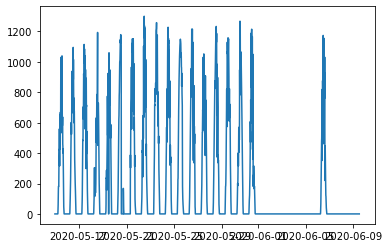

In [155]:
plt.plot(groups['1BY6WEcLGh8j5v7']['DATE_TIME'],groups['1BY6WEcLGh8j5v7']['AC_POWER'])

In [156]:
grouped.size()

SOURCE_KEY
1BY6WEcLGh8j5v7    2448
1IF53ai7Xc0U56Y    2448
3PZuoBAID5Wc2HD    2448
7JYdWkrLSPkdwr4    2448
McdE0feGgRqW7Ca    2448
VHMLBKoKgIrUVDU    2448
WRmjgnKYAwPKWDb    2448
YxYtjZvoooNbGkE    2448
ZnxXDlPa8U1GXgE    2448
ZoEaEvLYb1n2sOq    2448
adLQvlD726eNBSB    2448
bvBOhCH3iADSZry    2448
iCRJl6heRkivqQ3    2448
ih0vzX44oOqAx2f    2448
pkci93gMrogZuBj    2448
rGa61gmuvPhdLxV    2448
sjndEbLyjtCKgGv    2448
uHbuxQJl8lW7ozc    2448
wCURE6d3bPkepu2    2448
z9Y9gH1T5YWrNuG    2448
zBIq5rxdHJRwDNY    2448
zVJPv84UY57bAof    2448
dtype: int64

In [157]:
groups = dict(list(gd.groupby("SOURCE_KEY")))
groups

{'1BY6WEcLGh8j5v7':                 DATE_TIME       SOURCE_KEY  AMBIENT_TEMPERATURE  \
 0     2020-05-15 00:00:00  1BY6WEcLGh8j5v7            25.184316   
 22    2020-05-15 00:15:00  1BY6WEcLGh8j5v7            25.084589   
 44    2020-05-15 00:30:00  1BY6WEcLGh8j5v7            24.935753   
 66    2020-05-15 00:45:00  1BY6WEcLGh8j5v7            24.846130   
 88    2020-05-15 01:00:00  1BY6WEcLGh8j5v7            24.621525   
 ...                   ...              ...                  ...   
 53746 2020-06-09 10:45:00  1BY6WEcLGh8j5v7             0.000000   
 53768 2020-06-09 11:00:00  1BY6WEcLGh8j5v7             0.000000   
 53790 2020-06-09 11:15:00  1BY6WEcLGh8j5v7             0.000000   
 53812 2020-06-09 11:30:00  1BY6WEcLGh8j5v7             0.000000   
 53834 2020-06-09 11:45:00  1BY6WEcLGh8j5v7             0.000000   
 
        MODULE_TEMPERATURE  IRRADIATION   PLANT_ID  DC_POWER  AC_POWER  \
 0               22.857507          0.0  4135001.0       0.0       0.0   
 22            

# Shifting to create multisteps

In [158]:
#Focusing on a specific inverter

st=groups['1BY6WEcLGh8j5v7']
st

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,ARTIFICIAL,AC_power_mean_dif,date,time
0,2020-05-15 00:00:00,1BY6WEcLGh8j5v7,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:00:00
22,2020-05-15 00:15:00,1BY6WEcLGh8j5v7,25.084589,22.761668,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:15:00
44,2020-05-15 00:30:00,1BY6WEcLGh8j5v7,24.935753,22.592306,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:30:00
66,2020-05-15 00:45:00,1BY6WEcLGh8j5v7,24.846130,22.360852,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:45:00
88,2020-05-15 01:00:00,1BY6WEcLGh8j5v7,24.621525,22.165423,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53746,2020-06-09 10:45:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,10:45:00
53768,2020-06-09 11:00:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,11:00:00
53790,2020-06-09 11:15:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,11:15:00
53812,2020-06-09 11:30:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,11:30:00


In [159]:
#Adding 3 shifter DC POWER values and label column "FAULTY"

st['DC_POWER_shift_1']=st['DC_POWER'].shift(-1)
st['DC_POWER_shift_2']=st['DC_POWER'].shift(-2)
st['DC_POWER_shift_3']=st['DC_POWER'].shift(-3)
st['FAULTY']=np.random.randint(0, 2, st.shape[0])

#ignore NaN
st=st.fillna(value=0)
    
st

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,ARTIFICIAL,AC_power_mean_dif,date,time,DC_POWER_shift_1,DC_POWER_shift_2,DC_POWER_shift_3,FAULTY
0,2020-05-15 00:00:00,1BY6WEcLGh8j5v7,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:00:00,0.0,0.0,0.0,0
22,2020-05-15 00:15:00,1BY6WEcLGh8j5v7,25.084589,22.761668,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:15:00,0.0,0.0,0.0,0
44,2020-05-15 00:30:00,1BY6WEcLGh8j5v7,24.935753,22.592306,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:30:00,0.0,0.0,0.0,0
66,2020-05-15 00:45:00,1BY6WEcLGh8j5v7,24.846130,22.360852,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:45:00,0.0,0.0,0.0,1
88,2020-05-15 01:00:00,1BY6WEcLGh8j5v7,24.621525,22.165423,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,01:00:00,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53746,2020-06-09 10:45:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,10:45:00,0.0,0.0,0.0,0
53768,2020-06-09 11:00:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,11:00:00,0.0,0.0,0.0,0
53790,2020-06-09 11:15:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,11:15:00,0.0,0.0,0.0,1
53812,2020-06-09 11:30:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,11:30:00,0.0,0.0,0.0,1


In [160]:
#Train/test split
jaotaja = int(st['SOURCE_KEY'].size*0.8)

train_X = st.iloc[0: jaotaja,3:(st.columns.size-1)]
label_X = st.iloc[0: jaotaja,(st.columns.size-1)]

val_y = st.iloc[jaotaja:,3:(st.columns.size-1)]
label_y = st.iloc[jaotaja:,(st.columns.size-1)]


In [161]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

model1 = DecisionTreeClassifier() 
model2 = KNeighborsClassifier()
model3 = LogisticRegression()
model4 = BaggingClassifier()
model5 = svm.SVC()
model6 = GaussianNB()
model7 = linear_model.Ridge()
model8 = AdaBoostClassifier(n_estimators=100)
model9 = RandomForestClassifier(max_depth=2, random_state=0)

model1.fit(train_X,label_X)
model2.fit(train_X,label_X)
model3.fit(train_X,label_X)
model4.fit(train_X,label_X)
model5.fit(train_X,label_X)
model6.fit(train_X,label_X)
model7.fit(train_X,label_X)
model8.fit(train_X,label_X)
model9.fit(train_X,label_X)

print(f"Accuracy of DT {model1.score(val_y, label_y)*100}%")
print(f"Accuracy of NN {model2.score(val_y, label_y)*100}%")
print(f"Accuracy of LR {model3.score(val_y, label_y)*100}%")
print(f"Accuracy of BC {model4.score(val_y, label_y)*100}%")
print(f"Accuracy of SVM {model5.score(val_y, label_y)*100}%")
print(f"Accuracy of GNB {model6.score(val_y, label_y)*100}%")
print(f"Accuracy of LMR {model7.score(val_y, label_y)*100}%")
print(f"Accuracy of AB {model8.score(val_y, label_y)*100}%")
print(f"Accuracy of RF {model9.score(val_y, label_y)*100}%")

TypeError: invalid type promotion

### Fookus ühel päeval (2020-05-15)

In [194]:
gd[0:2112] # esimese päeva tunnused 22 inverteri kohta

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,ARTIFICIAL,AC_power_mean_dif,date,time
0,2020-05-15 00:00:00,1BY6WEcLGh8j5v7,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:00:00
1,2020-05-15 00:00:00,1IF53ai7Xc0U56Y,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6183645.0,0,-209.077138,2020-05-15,00:00:00
2,2020-05-15 00:00:00,3PZuoBAID5Wc2HD,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6987759.0,0,-209.077138,2020-05-15,00:00:00
3,2020-05-15 00:00:00,7JYdWkrLSPkdwr4,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,7602960.0,0,-209.077138,2020-05-15,00:00:00
4,2020-05-15 00:00:00,McdE0feGgRqW7Ca,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,7158964.0,0,-209.077138,2020-05-15,00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,2020-05-15 23:45:00,wCURE6d3bPkepu2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-05-15,23:45:00
2108,2020-05-15 23:45:00,z9Y9gH1T5YWrNuG,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-05-15,23:45:00
2109,2020-05-15 23:45:00,zBIq5rxdHJRwDNY,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-05-15,23:45:00
2110,2020-05-15 23:45:00,zVJPv84UY57bAof,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-05-15,23:45:00


In [195]:
diff_inv = gd.copy()
diff_inv['TIME'] = diff_inv['DATE_TIME'].dt.time
#diff_inv['DAY'] = diff_inv['DATE_TIME'].dt.day
diff_inv = diff_inv[0:2112] #generation[generation["SOURCE_KEY"]=="4UPUqMRk7TRMgml"][0:95]
print(diff_inv)

               DATE_TIME       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0    2020-05-15 00:00:00  1BY6WEcLGh8j5v7            25.184316   
1    2020-05-15 00:00:00  1IF53ai7Xc0U56Y            25.184316   
2    2020-05-15 00:00:00  3PZuoBAID5Wc2HD            25.184316   
3    2020-05-15 00:00:00  7JYdWkrLSPkdwr4            25.184316   
4    2020-05-15 00:00:00  McdE0feGgRqW7Ca            25.184316   
...                  ...              ...                  ...   
2107 2020-05-15 23:45:00  wCURE6d3bPkepu2             0.000000   
2108 2020-05-15 23:45:00  z9Y9gH1T5YWrNuG             0.000000   
2109 2020-05-15 23:45:00  zBIq5rxdHJRwDNY             0.000000   
2110 2020-05-15 23:45:00  zVJPv84UY57bAof             0.000000   
2111 2020-05-15 23:45:00  YxYtjZvoooNbGkE             0.000000   

      MODULE_TEMPERATURE  IRRADIATION   PLANT_ID  DC_POWER  AC_POWER  \
0              22.857507          0.0  4135001.0       0.0       0.0   
1              22.857507          0.0  4135001.0       0.0     

In [196]:
grouped_05_15 = diff_inv.groupby("SOURCE_KEY")
groups_05_15 = dict(list(grouped))
groups_05_15['VHMLBKoKgIrUVDU']


,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,ARTIFICIAL,AC_power_mean_dif,date,time
5,2020-05-15 00:00:00,VHMLBKoKgIrUVDU,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,7206408.0,0,-209.077138,2020-05-15,00:00:00
27,2020-05-15 00:15:00,VHMLBKoKgIrUVDU,25.084589,22.761668,0.0,4135001.0,0.0,0.0,0.0,7206408.0,0,-209.077138,2020-05-15,00:15:00
49,2020-05-15 00:30:00,VHMLBKoKgIrUVDU,24.935753,22.592306,0.0,4135001.0,0.0,0.0,0.0,7206408.0,0,-209.077138,2020-05-15,00:30:00
71,2020-05-15 00:45:00,VHMLBKoKgIrUVDU,24.846130,22.360852,0.0,4135001.0,0.0,0.0,0.0,7206408.0,0,-209.077138,2020-05-15,00:45:00
93,2020-05-15 01:00:00,VHMLBKoKgIrUVDU,24.621525,22.165423,0.0,4135001.0,0.0,0.0,0.0,7206408.0,0,-209.077138,2020-05-15,01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53751,2020-06-09 10:45:00,VHMLBKoKgIrUVDU,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,10:45:00
53773,2020-06-09 11:00:00,VHMLBKoKgIrUVDU,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,11:00:00
53795,2020-06-09 11:15:00,VHMLBKoKgIrUVDU,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,11:15:00
53817,2020-06-09 11:30:00,VHMLBKoKgIrUVDU,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,-209.077138,2020-06-09,11:30:00


In [167]:
groups_05_15['VHMLBKoKgIrUVDU']['DC_POWER'>0.0]

AttributeError: 'str' object has no attribute 'value'

In [198]:
a=np.float64(groups_05_15['VHMLBKoKgIrUVDU']['DC_POWER'])>0
b=np.array(np.nonzero(a))
kokku=0
for i in range(b.size):
    #print(b[0][i])
    kokku+=1

print(kokku)


871


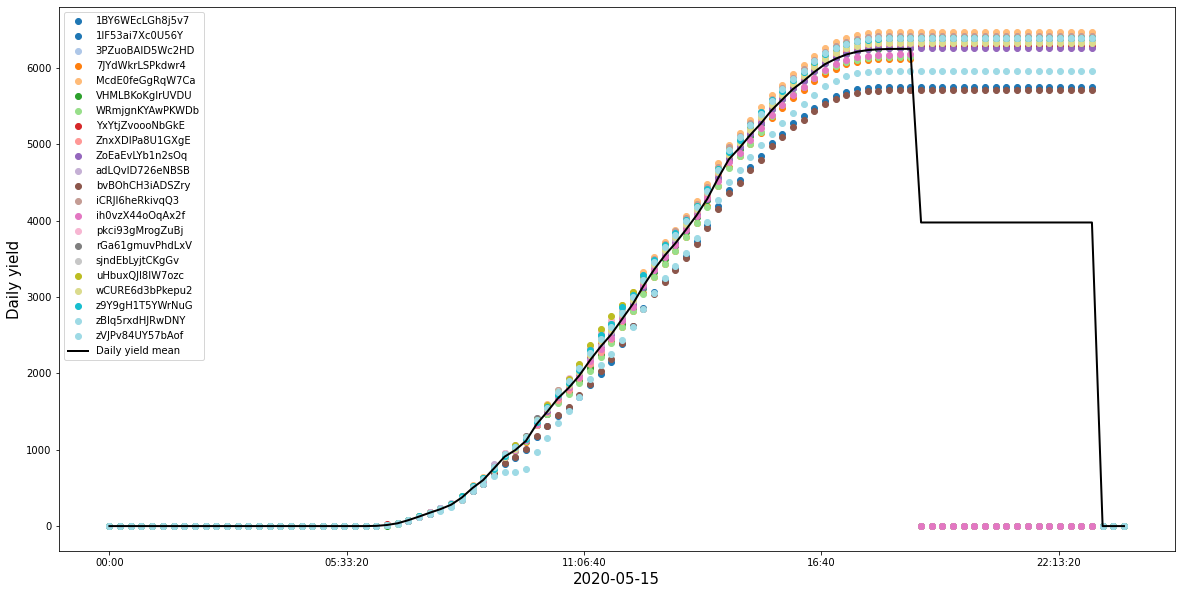

In [202]:
# ESIMESE PÄEVA DAILY YIELD IGA INVERTERI KOHTA
#inverter1 = generation[generation["SOURCE_KEY"]=="4UPUqMRk7TRMgml"]

diff_inv = gd.copy()
diff_inv['TIME'] = diff_inv['DATE_TIME'].dt.time
#diff_inv['DAY'] = diff_inv['DATE_TIME'].dt.day
diff_inv = diff_inv[0:2112] #generation[generation["SOURCE_KEY"]=="4UPUqMRk7TRMgml"][0:95]
#print(diff_inv[:10])

#plt.gca().set_prop_cycle(plt.cycler('color', colormap))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.tab20(np.linspace(0, 1, 22))))
diff_inv.set_index('TIME').groupby('SOURCE_KEY')['DAILY_YIELD'].plot(style='o', legend=True, figsize=(20,10))
diff_inv.groupby("TIME")["DAILY_YIELD"].agg('mean').plot(legend=True, color="black", label="Daily yield mean", linewidth=2)

plt.xlabel(diff_inv['DATE_TIME'].dt.date[0], size=15)
plt.ylabel('Daily yield', size=15)
plt.show()

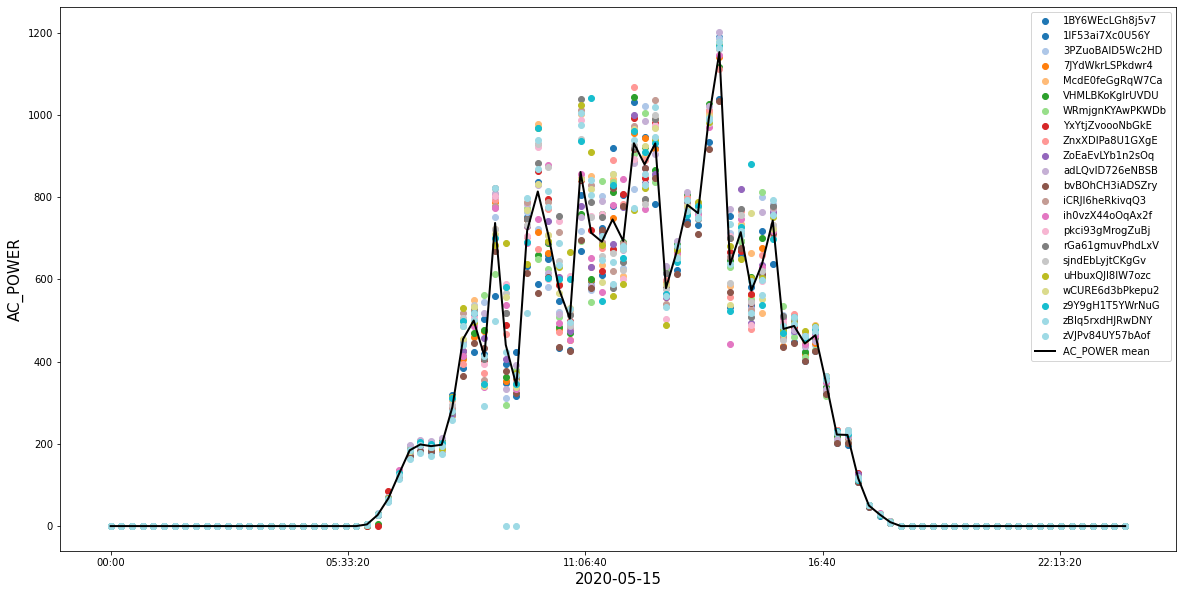

In [203]:
# ESIMESE PÄEVA DAILY YIELD IGA INVERTERI KOHTA
#inverter1 = generation[generation["SOURCE_KEY"]=="4UPUqMRk7TRMgml"]

diff_inv = gd.copy()
diff_inv['TIME'] = diff_inv['DATE_TIME'].dt.time
#diff_inv['DAY'] = diff_inv['DATE_TIME'].dt.day
diff_inv = diff_inv[0:2448] #generation[generation["SOURCE_KEY"]=="4UPUqMRk7TRMgml"][0:95]
#print(diff_inv[:10])

#plt.gca().set_prop_cycle(plt.cycler('color', colormap))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.tab20(np.linspace(0, 1, 22))))
diff_inv.set_index('TIME').groupby('SOURCE_KEY')['AC_POWER'].plot(style='o', legend=True, figsize=(20,10))
diff_inv.groupby("TIME")["AC_POWER"].agg('mean').plot(legend=True, color="black", label="AC_POWER mean", linewidth=2)

plt.xlabel(diff_inv['DATE_TIME'].dt.date[0], size=15)
plt.ylabel('AC_POWER', size=15)
plt.show()

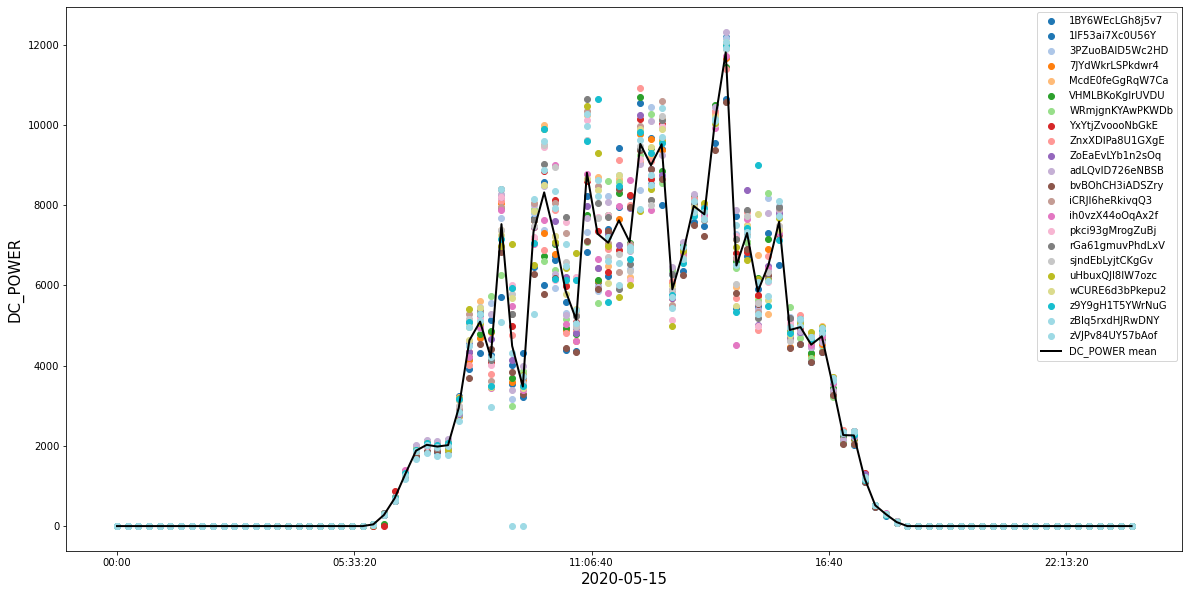

In [208]:
# ESIMESE PÄEVA DAILY YIELD IGA INVERTERI KOHTA
#inverter1 = generation[generation["SOURCE_KEY"]=="4UPUqMRk7TRMgml"]

diff_inv = gd.copy()
diff_inv['TIME'] = diff_inv['DATE_TIME'].dt.time
#diff_inv['DAY'] = diff_inv['DATE_TIME'].dt.day
diff_inv = diff_inv[0:2448] #generation[generation["SOURCE_KEY"]=="4UPUqMRk7TRMgml"][0:95]
#print(diff_inv[:10])

#plt.gca().set_prop_cycle(plt.cycler('color', colormap))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.tab20(np.linspace(0, 1, 22))))
diff_inv.set_index('TIME').groupby('SOURCE_KEY')['DC_POWER'].plot(style='o', legend=True, figsize=(20,10))
diff_inv.groupby("TIME")["DC_POWER"].agg('mean').plot(legend=True, color="black", label="DC_POWER mean", linewidth=2)

plt.xlabel(diff_inv['DATE_TIME'].dt.date[0], size=15)
plt.ylabel('DC_POWER', size=15)
plt.show()

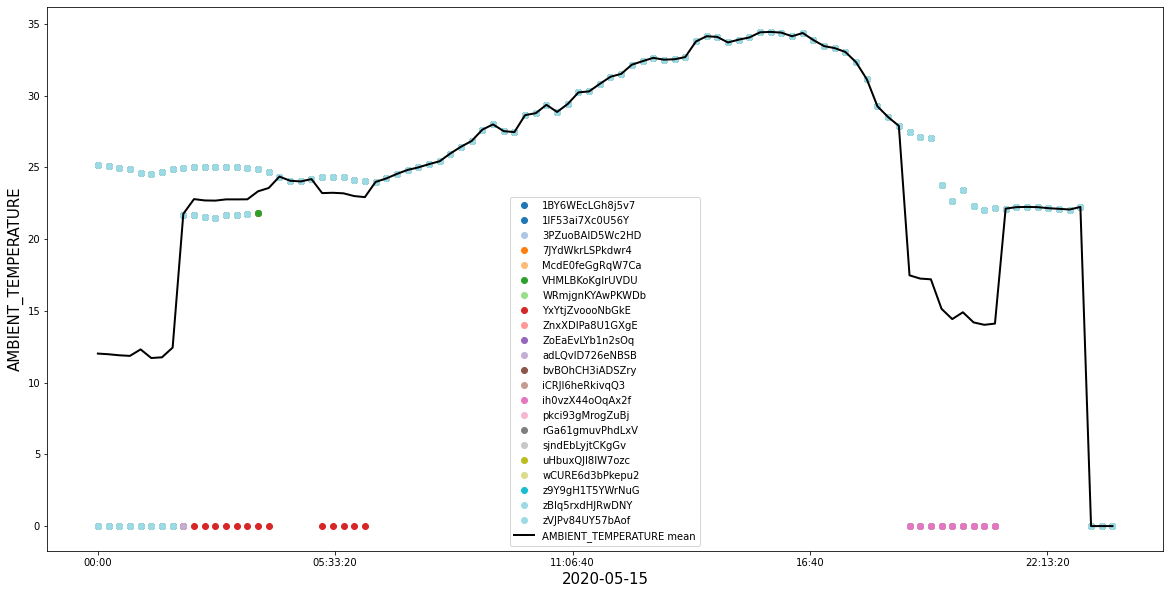

In [205]:
# ESIMESE PÄEVA DAILY YIELD IGA INVERTERI KOHTA
#inverter1 = generation[generation["SOURCE_KEY"]=="4UPUqMRk7TRMgml"]

diff_inv = gd.copy()
diff_inv['TIME'] = diff_inv['DATE_TIME'].dt.time
#diff_inv['DAY'] = diff_inv['DATE_TIME'].dt.day
diff_inv = diff_inv[0:2448] #generation[generation["SOURCE_KEY"]=="4UPUqMRk7TRMgml"][0:95]
#print(diff_inv[:10])

#plt.gca().set_prop_cycle(plt.cycler('color', colormap))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.tab20(np.linspace(0, 1, 22))))
diff_inv.set_index('TIME').groupby('SOURCE_KEY')['AMBIENT_TEMPERATURE'].plot(style='o', legend=True, figsize=(20,10))
diff_inv.groupby("TIME")["AMBIENT_TEMPERATURE"].agg('mean').plot(legend=True, color="black", label="AMBIENT_TEMPERATURE mean", linewidth=2)

plt.xlabel(diff_inv['DATE_TIME'].dt.date[0], size=15)
plt.ylabel('AMBIENT_TEMPERATURE', size=15)
plt.show()

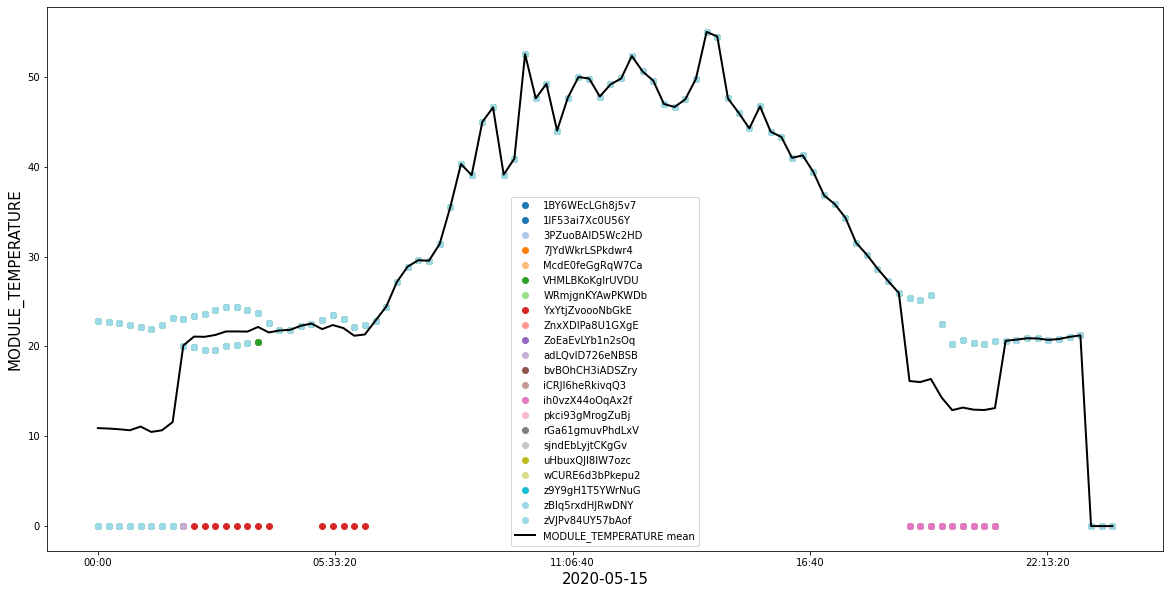

In [206]:
# ESIMESE PÄEVA DAILY YIELD IGA INVERTERI KOHTA
#inverter1 = generation[generation["SOURCE_KEY"]=="4UPUqMRk7TRMgml"]

diff_inv = gd.copy()
diff_inv['TIME'] = diff_inv['DATE_TIME'].dt.time
#diff_inv['DAY'] = diff_inv['DATE_TIME'].dt.day
diff_inv = diff_inv[0:2448] #generation[generation["SOURCE_KEY"]=="4UPUqMRk7TRMgml"][0:95]
#print(diff_inv[:10])

#plt.gca().set_prop_cycle(plt.cycler('color', colormap))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.tab20(np.linspace(0, 1, 22))))
diff_inv.set_index('TIME').groupby('SOURCE_KEY')['MODULE_TEMPERATURE'].plot(style='o', legend=True, figsize=(20,10))
diff_inv.groupby("TIME")["MODULE_TEMPERATURE"].agg('mean').plot(legend=True, color="black", label="MODULE_TEMPERATURE mean", linewidth=2)

plt.xlabel(diff_inv['DATE_TIME'].dt.date[0], size=15)
plt.ylabel('MODULE_TEMPERATURE', size=15)
plt.show()

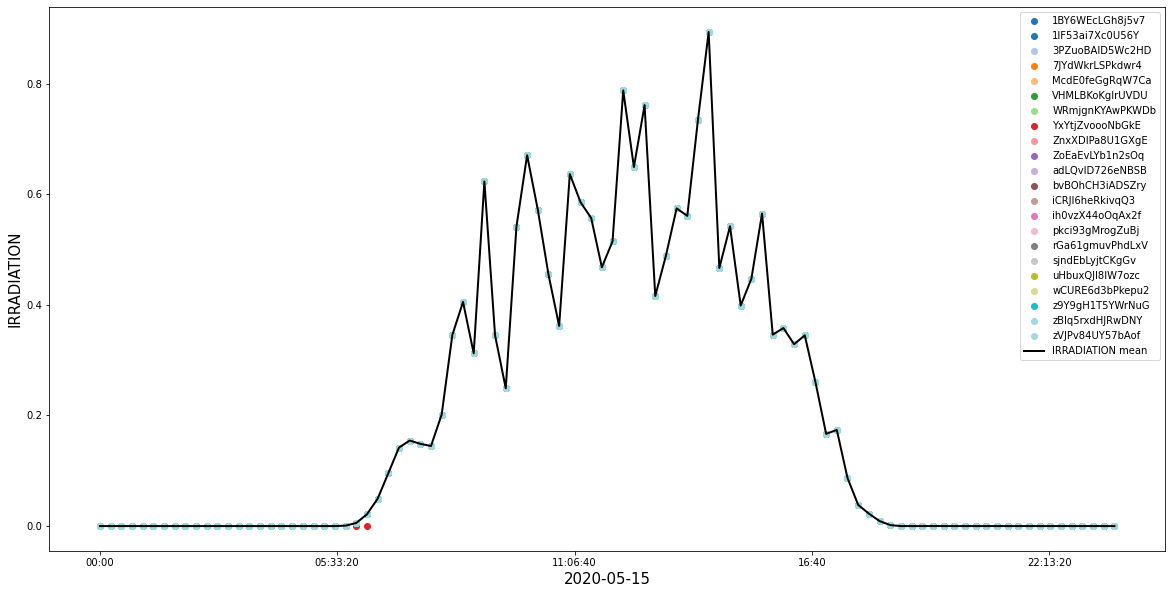

In [207]:
# ESIMESE PÄEVA DAILY YIELD IGA INVERTERI KOHTA
#inverter1 = generation[generation["SOURCE_KEY"]=="4UPUqMRk7TRMgml"]

diff_inv = gd.copy()
diff_inv['TIME'] = diff_inv['DATE_TIME'].dt.time
#diff_inv['DAY'] = diff_inv['DATE_TIME'].dt.day
diff_inv = diff_inv[0:2448] #generation[generation["SOURCE_KEY"]=="4UPUqMRk7TRMgml"][0:95]
#print(diff_inv[:10])

#plt.gca().set_prop_cycle(plt.cycler('color', colormap))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.tab20(np.linspace(0, 1, 22))))
diff_inv.set_index('TIME').groupby('SOURCE_KEY')['IRRADIATION'].plot(style='o', legend=True, figsize=(20,10))
diff_inv.groupby("TIME")["IRRADIATION"].agg('mean').plot(legend=True, color="black", label="IRRADIATION mean", linewidth=2)

plt.xlabel(diff_inv['DATE_TIME'].dt.date[0], size=15)
plt.ylabel('IRRADIATION', size=15)
plt.show()



In [177]:
diff_inv

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,ARTIFICIAL,AC_power_mean_dif,date,time,TIME
0,2020-05-15 00:00:00,1BY6WEcLGh8j5v7,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0,-209.077138,2020-05-15,00:00:00,00:00:00
1,2020-05-15 00:00:00,1IF53ai7Xc0U56Y,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6183645.0,0,-209.077138,2020-05-15,00:00:00,00:00:00
2,2020-05-15 00:00:00,3PZuoBAID5Wc2HD,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6987759.0,0,-209.077138,2020-05-15,00:00:00,00:00:00
3,2020-05-15 00:00:00,7JYdWkrLSPkdwr4,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,7602960.0,0,-209.077138,2020-05-15,00:00:00,00:00:00
4,2020-05-15 00:00:00,McdE0feGgRqW7Ca,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,7158964.0,0,-209.077138,2020-05-15,00:00:00,00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2443,2020-05-16 03:45:00,1IF53ai7Xc0U56Y,21.780166,20.505894,0.0,4135001.0,0.0,0.0,0.0,6190002.0,0,-209.077138,2020-05-16,03:45:00,03:45:00
2444,2020-05-16 03:45:00,3PZuoBAID5Wc2HD,21.780166,20.505894,0.0,4135001.0,0.0,0.0,0.0,6994033.0,0,-209.077138,2020-05-16,03:45:00,03:45:00
2445,2020-05-16 03:45:00,7JYdWkrLSPkdwr4,21.780166,20.505894,0.0,4135001.0,0.0,0.0,0.0,7609076.0,0,-209.077138,2020-05-16,03:45:00,03:45:00
2446,2020-05-16 03:45:00,McdE0feGgRqW7Ca,21.780166,20.505894,0.0,4135001.0,0.0,0.0,0.0,7165435.0,0,-209.077138,2020-05-16,03:45:00,03:45:00


In [181]:
#Check missing values percentage 
np.sum(diff_inv['ARTIFICIAL'])/diff_inv['ARTIFICIAL'].size

0.13725490196078433

In [333]:
uurimiseks= gd.copy()
uurimiseks_grupp=uurimiseks.groupby("SOURCE_KEY")
groups = dict(list(uurimiseks_grupp))
groups['1BY6WEcLGh8j5v7'][0:96]

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,ARTIFICIAL
0,2020-05-15 00:00:00,1BY6WEcLGh8j5v7,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0
22,2020-05-15 00:15:00,1BY6WEcLGh8j5v7,25.084589,22.761668,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0
44,2020-05-15 00:30:00,1BY6WEcLGh8j5v7,24.935753,22.592306,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0
66,2020-05-15 00:45:00,1BY6WEcLGh8j5v7,24.846130,22.360852,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0
88,2020-05-15 01:00:00,1BY6WEcLGh8j5v7,24.621525,22.165423,0.0,4135001.0,0.0,0.0,0.0,6259559.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2002,2020-05-15 22:45:00,1BY6WEcLGh8j5v7,22.057080,21.072276,0.0,4135001.0,0.0,0.0,5754.0,6265313.0,0
2024,2020-05-15 23:00:00,1BY6WEcLGh8j5v7,22.236018,21.241317,0.0,4135001.0,0.0,0.0,5754.0,6265313.0,0
2046,2020-05-15 23:15:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
2068,2020-05-15 23:30:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1


In [237]:
groups['1BY6WEcLGh8j5v7'].shape

(2448, 14)

In [238]:
for group in groups:
    print(groups[group].shape)

(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)
(2448, 14)


In [268]:
shift_nr=3
shift_columns = ['DC_POWER','AC_POWER','DAILY_YIELD','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']

for group in groups:
    for i in range(shift_nr):
        for j in range(len(shift_columns)):
            groups[group][shift_columns[j]+'_'+str(i+1)]=groups[group][shift_columns[j]].shift(-i+1)

    groups[group]['INVERTER']=group
    #groups[group]['FAULTY_DC']=0
    
#groups=groups.fillna(value=0)
print(groups)

{'1BY6WEcLGh8j5v7':                 DATE_TIME       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0     2020-05-15 00:00:00  1BY6WEcLGh8j5v7            25.184316   
22    2020-05-15 00:15:00  1BY6WEcLGh8j5v7            25.084589   
44    2020-05-15 00:30:00  1BY6WEcLGh8j5v7            24.935753   
66    2020-05-15 00:45:00  1BY6WEcLGh8j5v7            24.846130   
88    2020-05-15 01:00:00  1BY6WEcLGh8j5v7            24.621525   
...                   ...              ...                  ...   
53746 2020-06-09 10:45:00  1BY6WEcLGh8j5v7             0.000000   
53768 2020-06-09 11:00:00  1BY6WEcLGh8j5v7             0.000000   
53790 2020-06-09 11:15:00  1BY6WEcLGh8j5v7             0.000000   
53812 2020-06-09 11:30:00  1BY6WEcLGh8j5v7             0.000000   
53834 2020-06-09 11:45:00  1BY6WEcLGh8j5v7             0.000000   

       MODULE_TEMPERATURE  IRRADIATION   PLANT_ID  DC_POWER  AC_POWER  \
0               22.857507          0.0  4135001.0       0.0       0.0   
22              22.761668    

## TODO

* label "INCORRECT_total_yield" - yield per period decreases
* label "INCORRECT_according_to_DC_vs_AC" - DC and AC ratio is off
* label "INCORRECT_according_to_DC_AC_DAILY_YIELD" - DC and AC increases, while DAILY_YIELD does not

Group by date
* label "FAULTY_according_to_DAILY_YIELD" - yield stays the same, while other inverters still increases
* label "INCORRECT_daily_yield" - yield per day decreases
* columns per inverter day average differences (total are done)

GROUP_BY time
* columns "MOMENT_AVERAGE" - average value per this moment of inverter production info
* columns "DIF_FROM_AVERAGE" - inverter avg values in comparison with other inverters per this moment

In [316]:
#Generates new columns per inverter. Includes new columns:
# shifted (1 to shift_nr) - original field is shifted by x. Measurement value x measurements ago for this parameter
# INVERTER - same name as SOURCE_KEY in initial data set when used for grouping
# AC_DIF_AVG_PER_INVERTER - average inverter AC production - that moment production
# DC_DIF_AVG_PER_INVERTER - average inverter DC production - that moment production

shift_nr=3
shift_columns = ['DC_POWER','AC_POWER','DAILY_YIELD','TOTAL_YIELD','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']

gr_nr=0

#inverter based shifting
for group in groups:
    gr_nr+=1
    for i in range(shift_nr):
        for j in range(len(shift_columns)):
            groups[group][shift_columns[j]+'_'+str(i+1)]=groups[group][shift_columns[j]].shift(-i+1)

    groups[group]['INVERTER']=group
    groups[group]['AC_DIF_AVG_PER_INVERTER'] = np.mean(groups[group]['AC_POWER']) - groups[group]['AC_POWER']
    groups[group]['DC_DIF_AVG_PER_INVERTER'] = np.mean(groups[group]['DC_POWER']) - groups[group]['DC_POWER']
    
    if gr_nr==1:
        gen_data=pd.DataFrame(columns =groups[group].keys())
    
    #gen_data.append(groups[group], ignore_index=True) - did not seem to work and was replaced with concat
    gen_data=pd.concat([gen_data,groups[group]], ignore_index=True)
    
gen_data=gen_data.fillna(value=0)
gen_data

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,...,DAILY_YIELD_3,AMBIENT_TEMPERATURE_3,MODULE_TEMPERATURE_3,IRRADIATION_3,AC_AVG_DIF_PER_INVERTER,AC_DIF_AVG_PER_INVERTER,DC_DIF_AVG_PER_INVERTER,TOTAL_YIELD_1,TOTAL_YIELD_2,TOTAL_YIELD_3
0,2020-05-15 00:00:00,1BY6WEcLGh8j5v7,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6259559.0,...,0.0,25.084589,22.761668,0.0,197.340827,197.340827,2017.664611,0.0,6259559.0,6259559.0
1,2020-05-15 00:15:00,1BY6WEcLGh8j5v7,25.084589,22.761668,0.0,4135001.0,0.0,0.0,0.0,6259559.0,...,0.0,24.935753,22.592306,0.0,197.340827,197.340827,2017.664611,6259559.0,6259559.0,6259559.0
2,2020-05-15 00:30:00,1BY6WEcLGh8j5v7,24.935753,22.592306,0.0,4135001.0,0.0,0.0,0.0,6259559.0,...,0.0,24.846130,22.360852,0.0,197.340827,197.340827,2017.664611,6259559.0,6259559.0,6259559.0
3,2020-05-15 00:45:00,1BY6WEcLGh8j5v7,24.846130,22.360852,0.0,4135001.0,0.0,0.0,0.0,6259559.0,...,0.0,24.621525,22.165423,0.0,197.340827,197.340827,2017.664611,6259559.0,6259559.0,6259559.0
4,2020-05-15 01:00:00,1BY6WEcLGh8j5v7,24.621525,22.165423,0.0,4135001.0,0.0,0.0,0.0,6259559.0,...,0.0,24.536092,21.968571,0.0,197.340827,197.340827,2017.664611,6259559.0,6259559.0,6259559.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53851,2020-06-09 10:45:00,zVJPv84UY57bAof,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,210.659192,210.659192,2154.572792,0.0,0.0,0.0
53852,2020-06-09 11:00:00,zVJPv84UY57bAof,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,210.659192,210.659192,2154.572792,0.0,0.0,0.0
53853,2020-06-09 11:15:00,zVJPv84UY57bAof,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,210.659192,210.659192,2154.572792,0.0,0.0,0.0
53854,2020-06-09 11:30:00,zVJPv84UY57bAof,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,210.659192,210.659192,2154.572792,0.0,0.0,0.0


In [ ]:
# add inverter difference from average per that moment
'''
* columns "MOMENT_AVERAGE" - average value per this moment of inverter production info
* columns "DIF_FROM_AVERAGE" - inverter avg values in comparison with other inverters per this moment
'''






In [ ]:
shift_columns = ['DC_POWER','AC_POWER','DAILY_YIELD','TOTAL_YIELD','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']


In [332]:
gen_data.groupby("date").mean()

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,ARTIFICIAL,AC_power_mean_dif,...,AMBIENT_TEMPERATURE_3,MODULE_TEMPERATURE_3,IRRADIATION_3,AC_AVG_DIF_PER_INVERTER,AC_DIF_AVG_PER_INVERTER,DC_DIF_AVG_PER_INVERTER,TOTAL_YIELD_1,TOTAL_YIELD_2,TOTAL_YIELD_3,TOTAL_YIELD_ERROR
date,,,,,,,,,,,,,,,,,,,,,
2020-05-15,25.513843,30.583779,0.198288,3.825659e+06,2664.412473,260.810113,2392.798757,6.343179e+06,0.074811,51.732975,...,25.263431,30.356502,0.198288,-51.732975,-51.732975,-526.175127,6.343179e+06,6.343179e+06,6.275195e+06,0.015625
2020-05-16,24.528294,29.184939,0.194288,3.786502e+06,2749.118143,269.109764,3172.303318,6.284738e+06,0.084280,60.032626,...,24.780067,29.410267,0.194288,-60.032626,-60.032626,-610.880797,6.213222e+06,6.284738e+06,6.356253e+06,0.000000
2020-05-17,26.686727,32.740435,0.238869,4.135001e+06,3200.565600,312.961832,3695.106669,6.869208e+06,0.000000,103.884694,...,26.655326,32.729684,0.238869,-103.884694,-103.884694,-1062.328254,6.869130e+06,6.869208e+06,6.869286e+06,0.000000
2020-05-18,23.850938,27.814344,0.159026,4.135001e+06,2278.668814,222.997021,2429.114465,6.875446e+06,0.000000,13.919883,...,23.866097,27.814453,0.159026,-13.919883,-13.919883,-140.431468,6.875390e+06,6.875446e+06,6.875502e+06,0.000000
2020-05-19,23.872439,28.091407,0.186004,3.896142e+06,2574.789229,252.012543,2791.818523,6.490246e+06,0.057765,42.935405,...,23.870921,28.086211,0.186004,-42.935405,-42.935405,-436.551883,6.490175e+06,6.490246e+06,6.490317e+06,0.012311
2020-05-20,19.910957,23.578766,0.190058,3.273542e+06,2545.258414,248.619587,2657.450785,5.453422e+06,0.208333,39.542449,...,19.676944,23.369275,0.190058,-39.542449,-39.542449,-407.021068,5.525143e+06,5.453422e+06,5.381701e+06,0.020833
2020-05-21,18.137833,24.985082,0.245342,2.678353e+06,3210.733023,313.798508,3137.927430,4.472686e+06,0.352273,104.721370,...,18.385339,25.206282,0.245342,-104.721370,-104.721370,-1072.495677,4.400793e+06,4.472686e+06,4.544579e+06,0.003788
2020-05-22,25.444268,31.462028,0.230407,3.970541e+06,3040.096828,297.268044,2630.649221,6.623903e+06,0.039773,88.190905,...,25.423004,31.454072,0.230407,-88.190905,-88.190905,-901.859482,6.623828e+06,6.623903e+06,6.623977e+06,0.005682
2020-05-23,24.934016,32.408030,0.271944,3.833491e+06,3612.792226,353.164909,4009.939887,6.409095e+06,0.072917,144.087771,...,24.964969,32.425781,0.271944,-144.087771,-144.087771,-1474.554880,6.409006e+06,6.409095e+06,6.409183e+06,0.020833


In [ ]:
# TODO method that shifts based on grouped info and adds dif to mean?

In [335]:
#uurimiseks= gen_data.copy()
#uurimiseks_grupp=gen_data.copy().groupby("SOURCE_KEY")
groups = dict(list(gen_data.copy().groupby("SOURCE_KEY")))
groups['1BY6WEcLGh8j5v7'][0:96]

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,...,AMBIENT_TEMPERATURE_3,MODULE_TEMPERATURE_3,IRRADIATION_3,AC_AVG_DIF_PER_INVERTER,AC_DIF_AVG_PER_INVERTER,DC_DIF_AVG_PER_INVERTER,TOTAL_YIELD_1,TOTAL_YIELD_2,TOTAL_YIELD_3,TOTAL_YIELD_ERROR
0,2020-05-15 00:00:00,1BY6WEcLGh8j5v7,25.184316,22.857507,0.0,4135001.0,0.0,0.0,0.0,6259559.0,...,25.084589,22.761668,0.0,197.340827,197.340827,2017.664611,0.0,6259559.0,6259559.0,0
1,2020-05-15 00:15:00,1BY6WEcLGh8j5v7,25.084589,22.761668,0.0,4135001.0,0.0,0.0,0.0,6259559.0,...,24.935753,22.592306,0.0,197.340827,197.340827,2017.664611,6259559.0,6259559.0,6259559.0,0
2,2020-05-15 00:30:00,1BY6WEcLGh8j5v7,24.935753,22.592306,0.0,4135001.0,0.0,0.0,0.0,6259559.0,...,24.846130,22.360852,0.0,197.340827,197.340827,2017.664611,6259559.0,6259559.0,6259559.0,0
3,2020-05-15 00:45:00,1BY6WEcLGh8j5v7,24.846130,22.360852,0.0,4135001.0,0.0,0.0,0.0,6259559.0,...,24.621525,22.165423,0.0,197.340827,197.340827,2017.664611,6259559.0,6259559.0,6259559.0,0
4,2020-05-15 01:00:00,1BY6WEcLGh8j5v7,24.621525,22.165423,0.0,4135001.0,0.0,0.0,0.0,6259559.0,...,24.536092,21.968571,0.0,197.340827,197.340827,2017.664611,6259559.0,6259559.0,6259559.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2020-05-15 22:45:00,1BY6WEcLGh8j5v7,22.057080,21.072276,0.0,4135001.0,0.0,0.0,5754.0,6265313.0,...,22.236018,21.241317,0.0,197.340827,197.340827,2017.664611,6265313.0,6265313.0,6265313.0,0
92,2020-05-15 23:00:00,1BY6WEcLGh8j5v7,22.236018,21.241317,0.0,4135001.0,0.0,0.0,5754.0,6265313.0,...,0.000000,0.000000,0.0,197.340827,197.340827,2017.664611,6265313.0,6265313.0,0.0,0
93,2020-05-15 23:15:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,197.340827,197.340827,2017.664611,6265313.0,0.0,0.0,1
94,2020-05-15 23:30:00,1BY6WEcLGh8j5v7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,197.340827,197.340827,2017.664611,0.0,0.0,0.0,0


In [341]:
#TODO meetod mis grupeerib tunnuse alusel ja arvutab etteantud tulpade kohta erinevuse sellest tunnusest grupis

def group_avg(data_frame,columnid, group_by):
    grouped=dict(list(data_frame.copy.groupby(data_frame[group_by])))
    gr_nr=0
    
    for group in grouped:
        gr_nr+=1
        for column in columnid:
            grouped[group][column+"_AVG"] = np.mean(grouped[group][column]) - grouped[group][column]
        if gr_nr==1:
            ajutine_gen_data=pd.DataFrame(columns = grouped[group].keys())
        ajutine_gen_data=pd.concat([ajutine_gen_data,grouped[group]], ignore_index=True)
    return(ajutine_gen_data)

In [343]:
test = gen_data.copy()
tulbad=['DC_POWER','AC_POWER']

print(group_avg(test, tulbad, 'date'))


AttributeError: 'function' object has no attribute 'groupby'

In [ ]:
#TODO meetod mis grupeerib tunnuse alusel ja arvutab etteantud tulpade kohta erinevuse sellest tunnusest grupis

def group_avg(data_frame,columnid, group_by):
    grouped=dict(list(data_frame.copy.groupby(group_by)))
    gr_nr=0
    
    for group in grouped:
        gr_nr+=1
        for column in columnid:
            grouped[group][column+"_AVG"] = np.mean(grouped[group][column]) - grouped[group][column]
        if gr_nr==1:
            ajutine_gen_data=pd.DataFrame(columns = grouped[group].keys())
        ajutine_gen_data=pd.concat([ajutine_gen_data,grouped[group]], ignore_index=True)
    return(ajutine_gen_data)
    
    --------------
shift_nr=3
shift_columns = ['DC_POWER','AC_POWER','DAILY_YIELD','TOTAL_YIELD','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']

gr_nr=0

#inverter based shifting
for group in groups:
    gr_nr+=1
    for i in range(shift_nr):
        for j in range(len(shift_columns)):
            groups[group][shift_columns[j]+'_'+str(i+1)]=groups[group][shift_columns[j]].shift(-i+1)

    groups[group]['INVERTER']=group
    groups[group]['AC_DIF_AVG_PER_INVERTER'] = np.mean(groups[group]['AC_POWER']) - groups[group]['AC_POWER']
    groups[group]['DC_DIF_AVG_PER_INVERTER'] = np.mean(groups[group]['DC_POWER']) - groups[group]['DC_POWER']
    
    if gr_nr==1:
        gen_data=pd.DataFrame(columns =groups[group].keys())
    
    #gen_data.append(groups[group], ignore_index=True) - did not seem to work and was replaced with concat
    gen_data=pd.concat([gen_data,groups[group]], ignore_index=True)
    
gen_data=gen_data.fillna(value=0)
gen_data


In [ ]:
#Group by day labels
'''
* label "FAULTY_according_to_DAILY_YIELD" - yield stays the same, while other inverters still increases
* label "INCORRECT_daily_yield" - yield per day decreases
* columns per inverter day average differences (total are done)
'''

gen_data['DAILY_YIELD_ERROR']


In [312]:
#other labels adding
'''
* label "INCORRECT_total_yield" - yield per period decreases
* label "INCORRECT_according_to_DC_vs_AC" - DC and AC ratio is off
* label "INCORRECT_according_to_DC_AC_DAILY_YIELD" - DC and AC increases, while DAILY_YIELD does not
'''

a=sum(gen_data['AC_POWER']<gen_data['AC_POWER_1'])/gen_data['AC_POWER'].size
print(f'Percent of AC_POWER being less then previous moment',{a})

b=sum(gen_data['AC_POWER']>gen_data['AC_POWER_1'])/gen_data['AC_POWER'].size
print(f'Percent of AC_POWER being more then previous moment',{b})

c=sum(gen_data['AC_POWER']==gen_data['AC_POWER_1'])/gen_data['AC_POWER'].size
print(f'Percent of AC_POWER being same then previous moment',{c})



Percent of AC_POWER being less then previous moment {0.17771464646464646}
Percent of AC_POWER being more then previous moment {0.1854575163398693}
Percent of AC_POWER being same then previous moment {0.6368278371954843}


In [319]:

'''
* label "INCORRECT_total_yield" - yield per period decreases
* label "INCORRECT_according_to_DC_vs_AC" - DC and AC ratio is off
* label "INCORRECT_according_to_DC_AC_DAILY_YIELD" - DC and AC increases, while DAILY_YIELD does not
'''

a=sum(gen_data['TOTAL_YIELD']<gen_data['TOTAL_YIELD_1'])/gen_data['TOTAL_YIELD'].size
print(f'Percent of TOTAL_YIELD being less then previous moment',{a})

b=sum(gen_data['TOTAL_YIELD']>gen_data['TOTAL_YIELD_1'])/gen_data['TOTAL_YIELD'].size
print(f'Percent of TOTAL_YIELD being more then previous moment',{b})

c=sum(gen_data['TOTAL_YIELD']==gen_data['TOTAL_YIELD_1'])/gen_data['TOTAL_YIELD'].size
print(f'Percent of TOTAL_YIELD being same then previous moment',{c})



Percent of TOTAL_YIELD being less then previous moment {0.005718954248366013}
Percent of TOTAL_YIELD being more then previous moment {0.3624294414735591}
Percent of TOTAL_YIELD being same then previous moment {0.6318516042780749}


In [321]:
gen_data['TOTAL_YIELD_ERROR']=np.where(gen_data['TOTAL_YIELD']<gen_data['TOTAL_YIELD_1'],1,0)
sum(gen_data['TOTAL_YIELD_ERROR'])

308

In [325]:
gen_data.loc[gen_data.index[gen_data['TOTAL_YIELD_ERROR']==1]]

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,...,AMBIENT_TEMPERATURE_3,MODULE_TEMPERATURE_3,IRRADIATION_3,AC_AVG_DIF_PER_INVERTER,AC_DIF_AVG_PER_INVERTER,DC_DIF_AVG_PER_INVERTER,TOTAL_YIELD_1,TOTAL_YIELD_2,TOTAL_YIELD_3,TOTAL_YIELD_ERROR
93,2020-05-15 23:15:00,1BY6WEcLGh8j5v7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,197.340827,197.340827,2017.664611,6265313.000,0.0,0.0,1
431,2020-05-19 11:45:00,1BY6WEcLGh8j5v7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,197.340827,197.340827,2017.664611,6285878.750,0.0,0.0,1
534,2020-05-20 13:30:00,1BY6WEcLGh8j5v7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,197.340827,197.340827,2017.664611,6295430.167,0.0,0.0,1
572,2020-05-20 23:00:00,1BY6WEcLGh8j5v7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,197.340827,197.340827,2017.664611,6298346.000,0.0,0.0,1
789,2020-05-23 05:15:00,1BY6WEcLGh8j5v7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,197.340827,197.340827,2017.664611,6312437.000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52746,2020-05-28 22:30:00,zVJPv84UY57bAof,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,210.659192,210.659192,2154.572792,7220473.000,0.0,0.0,1
52826,2020-05-29 18:30:00,zVJPv84UY57bAof,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,210.659192,210.659192,2154.572792,7228687.000,0.0,0.0,1
53040,2020-06-01 00:00:00,zVJPv84UY57bAof,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,210.659192,210.659192,2154.572792,7242024.000,0.0,0.0,1
53593,2020-06-06 18:15:00,zVJPv84UY57bAof,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,210.659192,210.659192,2154.572792,7285530.000,0.0,0.0,1


In [326]:
gen_data.loc[gen_data.index[gen_data['TOTAL_YIELD']==0]]

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,...,AMBIENT_TEMPERATURE_3,MODULE_TEMPERATURE_3,IRRADIATION_3,AC_AVG_DIF_PER_INVERTER,AC_DIF_AVG_PER_INVERTER,DC_DIF_AVG_PER_INVERTER,TOTAL_YIELD_1,TOTAL_YIELD_2,TOTAL_YIELD_3,TOTAL_YIELD_ERROR
93,2020-05-15 23:15:00,1BY6WEcLGh8j5v7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,197.340827,197.340827,2017.664611,6265313.0,0.0,0.0,1
94,2020-05-15 23:30:00,1BY6WEcLGh8j5v7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,197.340827,197.340827,2017.664611,0.0,0.0,0.0,0
95,2020-05-15 23:45:00,1BY6WEcLGh8j5v7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,197.340827,197.340827,2017.664611,0.0,0.0,0.0,0
96,2020-05-16 00:00:00,1BY6WEcLGh8j5v7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,197.340827,197.340827,2017.664611,0.0,0.0,0.0,0
97,2020-05-16 00:15:00,1BY6WEcLGh8j5v7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,197.340827,197.340827,2017.664611,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53851,2020-06-09 10:45:00,zVJPv84UY57bAof,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,210.659192,210.659192,2154.572792,0.0,0.0,0.0,0
53852,2020-06-09 11:00:00,zVJPv84UY57bAof,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,210.659192,210.659192,2154.572792,0.0,0.0,0.0,0
53853,2020-06-09 11:15:00,zVJPv84UY57bAof,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,210.659192,210.659192,2154.572792,0.0,0.0,0.0,0
53854,2020-06-09 11:30:00,zVJPv84UY57bAof,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,210.659192,210.659192,2154.572792,0.0,0.0,0.0,0


In [318]:
groups[group].keys()

Index(['DATE_TIME', 'SOURCE_KEY', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
       'IRRADIATION', 'PLANT_ID', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD',
       'TOTAL_YIELD', 'ARTIFICIAL', 'AC_power_mean_dif', 'date', 'time',
       'DC_POWER_shift_1', 'DC_POWER_shift_2', 'DC_POWER_shift_3', 'INVERTER',
       'AC_POWER_shift_1', 'DAILY_YIELD_shift_1', 'AC_POWER_shift_2',
       'DAILY_YIELD_shift_2', 'AC_POWER_shift_3', 'DAILY_YIELD_shift_3',
       'AMBIENT_TEMPERATURE_shift_1', 'MODULE_TEMPERATURE_shift_1',
       'IRRADIATION_shift_1', 'AMBIENT_TEMPERATURE_shift_2',
       'MODULE_TEMPERATURE_shift_2', 'IRRADIATION_shift_2',
       'AMBIENT_TEMPERATURE_shift_3', 'MODULE_TEMPERATURE_shift_3',
       'IRRADIATION_shift_3', 'DC_POWER_1', 'AC_POWER_1', 'DAILY_YIELD_1',
       'AMBIENT_TEMPERATURE_1', 'MODULE_TEMPERATURE_1', 'IRRADIATION_1',
       'DC_POWER_2', 'AC_POWER_2', 'DAILY_YIELD_2', 'AMBIENT_TEMPERATURE_2',
       'MODULE_TEMPERATURE_2', 'IRRADIATION_2', 'DC_POWER_3', 'AC_POWER

In [178]:
diff_inv.groupby("SOURCE_KEY")

In [128]:
diff_inv.set_index('TIME').groupby('SOURCE_KEY')['DAILY_YIELD']

In [133]:
diff_inv.loc['DC_POWER'!=0, 'label'] = 0

KeyError: 'cannot use a single bool to index into setitem'

In [ ]:
#Per inverter new columns
uurimiseks= gd.copy()
groups = dict(list(uurimiseks.groupby("SOURCE_KEY")))

shift_nr=3
shift_columns = ['DC_POWER','AC_POWER','DAILY_YIELD','TOTAL_YIELD','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']

gr_nr=0

#inverter based shifting
for group in groups:
    gr_nr+=1
    for i in range(shift_nr):
        for j in range(len(shift_columns)):
            groups[group][shift_columns[j]+'_PER_INVERTER_MOMENT_SHIFT_MINUS_'+str(i+1)]=groups[group][shift_columns[j]].shift(periods=-(i+1), fill_value=0)
            groups[group][shift_columns[j]+'_PER_INVERTER_DAY_SHIFT_MINUS_'+str(i+1)]=groups[group][shift_columns[j]].shift(periods=-(i+1)*96, fill_value=0)

            
    #groups[group]['INVERTER']=group - ebaoluline
    groups[group]['AC_DIF_AVG_PER_INVERTER'] = groups[group]['AC_POWER'] - np.mean(groups[group]['AC_POWER']) 
    groups[group]['DC_DIF_AVG_PER_INVERTER'] = groups[group]['DC_POWER'] - np.mean(groups[group]['DC_POWER']) 
    
    if gr_nr==1:
        gen_data=pd.DataFrame(columns = groups[group].keys())
    
    #gen_data.append(groups[group], ignore_index=True) - did not seem to work and was replaced with concat
    gen_data=pd.concat([gen_data,groups[group]], ignore_index=True)
    
#gen_data=gen_data.fillna(value=0) - ebaoluline
gen_data

Taskid:
    1. tulp "FAULTY" - alguses suvaliselt 0 ja 1'ga, hiljem juba andmete pealt mingi loogikaga
    2. Katsetada milliseid välju peaks shiftima ja kui palju (AC_POWER, DC_POWER, DAILY_YIELD, TOTAL_YIELD + ilma tulbad)
    3. kas ühe inverteri ennustamisel mängib olulist rolli ka teiste inverterite sama aja tootlus ja kuidas neid andmeid kokku liita? Kas üks tabel, kus lisa veerud iga teise inverteri jaoks või tensor?
    4. DONE - train/test split
    5. Models: 
    DONE , but incorrect alpha - linear regression
    DONE -logistic regression
    DONE - k-nearest neighbor
    neural networks
    DONE - support vector classifier
    DONE - random forest classifier 
    DONE - decision tree classifier - from sklearn.tree import DecisionTreeClassifier
    DONE - gaussian NaiveBayes
    DONE - Ada boost
    DONE - bagging classifier - from sklearn.ensemble import BaggingClassifier
    ensamble veel?
    6. puudu olevad andmed ja nende asendumisel lisatud 0?
    7. Kas ennustusest võiks jätta valjä kõik kus DC_POWER = 0, ehk öösel päikest pole või peaks seda tegema aja pealt kuidagi (ka päeval võib tootmine nulli minna)
    
    